In [1]:
from utility.utils import *
from dataset.dataset import *
from dataset.transform import *
from model.loss import *
from model.unet import UNet256_3x3
from training.classifier import NucleiClassifier
from model.eval import *
from dataset.submission import *

import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim

from skimage.morphology import label
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2
import shutil
import os

### Create Random (Stratified) Train and Validation Set - RUN AS NEEDED

In [3]:
classes = pd.read_csv('classes.csv')
train_dirs, valid_dirs = get_stratified_valid_dirs(classes, seed=17)

In [4]:
main_path = '../data/ds_bowl_2018/'
full_path = '../data/ds_bowl_2018/full_data/'

In [5]:
create_validation_dirs(main_path, full_path, None, train_dirs, valid_dirs)

Copied 606 training and 64 validation data


In [6]:
# test distribution
classes[~classes.is_train].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             1         1
           white              3         3
           yellow             8         8
white      black             53        53

In [7]:
# distributions seem similar to test
classes[classes.filename.isin([f + '.png' for f in valid_dirs])].groupby(['foreground', 'background']).count()

filename  is_train
foreground background                    
purple     purple             2         2
           white              4         4
white      black             58        58

### Training Data Prep

In multiclass UNET we will not be outputing a single channel like we did for binary classification background or mask but rather this time we will have a 3 channel output. Each channel will correspond to probability distributions for background, mask and overlap. We will be using multiclass BCE Loss.

Output Channels:

- Background
- Foreground
- Overlap


If there are 3 unique pixel intensities

- 30 : Background
- 110 : Nuclei
- 215 : Overlap Boundary

If there are 2 unique pixel intensities

- 30 : Background
- 215 : Nuclei

w_background, w_nuclei, w_overlap = (1.1551767249306626, 7.544967099214484, 557.753645718466)

In [2]:
train_path = '../data/ds_bowl_2018/train/'
valid_path = '../data/ds_bowl_2018/valid/'
dummy_path = '../data/ds_bowl_2018/dummy/'

In [3]:
train_dirs = list_directory(train_path)
valid_dirs = list_directory(valid_path)
dummy_dirs = list_directory(dummy_path)

In [4]:
list_directory(train_dirs[0])

['../data/ds_bowl_2018/train/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/images/',
 '../data/ds_bowl_2018/train/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/one_mask.png/',
 '../data/ds_bowl_2018/train/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/mclass_one_mask.png/',
 '../data/ds_bowl_2018/train/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/masks/']

In [5]:
len(train_dirs), len(valid_dirs), len(dummy_dirs)

(606, 64, 1)

In [6]:
def get_3d_mask(mask):
    if len(np.unique(mask)) == 2:
        back_channel = (mask == 30)*1 # background
        nuclei_channel = (mask == 215)*1 # nuclei
        overlap_channel = np.zeros_like(mask) # overlap - missing so all 0s
    else:
        back_channel = (mask == 30)*1 # background
        nuclei_channel = (mask == 110)*1 # nuclei
        overlap_channel = (mask == 215)*1 # overlap
    # stack depth-wise
    multiclass_mask = np.dstack([back_channel, nuclei_channel, overlap_channel])
    return multiclass_mask

In [7]:
def train_augment(image, mask, index, sz = 256):           
    # get 3d mask
    mask3d = get_3d_mask(mask).astype(np.uint8) 
    # resize image, mask for Unet256
    image = fix_resize_transform(image, sz, sz)
    mask3d = fix_resize_transform(mask3d, sz, sz) 
    # get dimensions right for pytorch
    image = (image.transpose((2,0,1))) / 255 
    mask3d = (mask3d.transpose((2,0,1)))
    return image.astype(np.float64), mask3d.astype(np.float64), index

def valid_augment(image, mask, index, sz = 256):        
    # get 3d mask
    mask3d = get_3d_mask(mask).astype(np.uint8) 
    # resize image, mask for Unet256
    image = fix_resize_transform(image, sz, sz)
    mask3d = fix_resize_transform(mask3d, sz, sz) 
    # get dimensions right for pytorch
    image = (image.transpose((2,0,1))) / 255 
    mask3d = (mask3d.transpose((2,0,1)))
    return image.astype(np.float64), mask3d.astype(np.float64), index


def test_augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image = fix_resize_transform(image, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    return image.astype(np.float64), index

In [36]:
# create dummyloader
dummy_ds = NucleiDataset('../data/ds_bowl_2018/dummy/', transform=train_augment, mode='train', mask_file='/mclass_one_mask.png')
dummy_dl = DataLoader(dummy_ds, batch_size=1, shuffle=False)
# create trainloader
trn_ds = NucleiDataset('../data/ds_bowl_2018/train/', transform=train_augment, mode='train', mask_file='/mclass_one_mask.png')
trn_dl = DataLoader(trn_ds, batch_size=8, shuffle=True)
# create validloader.png
val_ds = NucleiDataset('../data/ds_bowl_2018/valid/', transform=valid_augment, mode='valid', mask_file='/mclass_one_mask.png')
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)
# create testloader
test_ds = NucleiDataset('../data/ds_bowl_2018/test/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [37]:
class Weighted_BCELoss2d(nn.Module):
    """
    Weights for a single sample which is repeated along the batch
    Inputs:
        weight: weigth tensor for a single sample
    """
    def __init__(self, weight=None):
        super(Weighted_BCELoss2d, self).__init__()
        self.weight = weight
        
    def forward(self, logits, targets):
        # contruct bce loss
        batch_size = targets.size(0)
        weights = self.weight.repeat(batch_size)
        bce_loss = nn.BCELoss(weights)
        # calc loss
        probs        = F.sigmoid(logits)
        probs_flat   = probs.view (-1)
        targets_flat = targets.view(-1)
        return bce_loss(probs_flat, targets_flat)

In [172]:
w_background, w_nuclei, w_overlap = (1.155, 7.544, 557.753)
weights = torch.cat([torch.ones(256*256)*w_background, 
                     torch.ones(256*256)*w_nuclei, torch.ones(256*256)*w_overlap]).double()

In [173]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=3).double()
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters(), lr=0.01)
# weighted BCELoss
crit = Weighted_BCELoss2d(weights)

In [174]:
# init classifier
classifier = NucleiClassifier(net, 1000)

In [200]:
# train for 10 epochs
classifier.train(train_loader=dummy_dl, valid_loader=dummy_dl, optimizer=optimizer,crit=crit, epochs=20, threshold=0.5)

Epoch: 186
Training : [0.1159],Validation : [0.3826]
Epoch: 187
Training : [0.1147],Validation : [0.3467]
Epoch: 188
Training : [0.1242],Validation : [0.3864]
Epoch: 189
Training : [0.1179],Validation : [0.374]
Epoch: 190
Training : [0.1115],Validation : [0.3399]
Epoch: 191
Training : [0.1119],Validation : [0.3592]
Epoch: 192
Training : [0.1078],Validation : [0.363]
Epoch: 193
Training : [0.106],Validation : [0.3583]
Epoch: 194
Training : [0.1172],Validation : [0.3825]
Epoch: 195
Training : [0.1063],Validation : [0.3583]
Epoch: 196
Training : [0.1015],Validation : [0.3751]
Epoch: 197
Training : [0.1014],Validation : [0.3934]
Epoch: 198
Training : [0.1077],Validation : [0.3704]
Epoch: 199
Training : [0.1177],Validation : [0.418]
Epoch: 200
Training : [0.1158],Validation : [0.3962]
Epoch: 201
Training : [0.1082],Validation : [0.4368]
Epoch: 202
Training : [0.1203],Validation : [0.3862]
Epoch: 203
Training : [0.1034],Validation : [0.3871]
Epoch: 204
Training : [0.0998],Validation : [0.383

In [201]:
samples = iter(dummy_dl)

In [202]:
sample = next(samples)

In [203]:
inp = V(sample[0])

In [204]:
out = classifier.net(inp)

In [205]:
# get the class index by max logit
_, out_mask = torch.max(out[0], 0)

In [206]:
np.unique(out_mask.data.numpy())

array([0, 1])

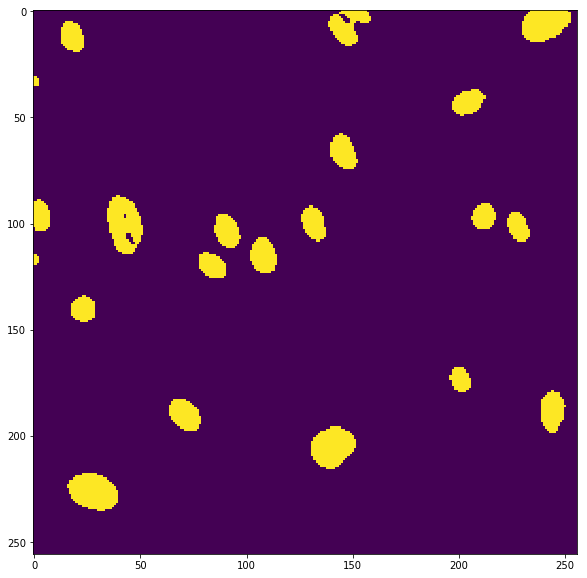

In [207]:
show_with_sz(out_mask.data.numpy())